# G5 Final Project
## **0. Introduction**
**Project Title:** Zestimate<br>
**Group Member:** Remeeliz Agbayani (3181-3601) & Milena Darling<br>
<br>
**Summary:** This overall goal of this project is being able to correctly predicate housing value. We believe the requirements for the entire scope of this project maybe too large for the amount of time, there are 56 different attributes. We will first focus on identifying the strongest correlated attributes to each other and then compare to pricing.
<br>
**Problem Statement** How do property attributes affect property value?
<br><br>
***Approach***
    1. Analyze training data
    2. Identify attributes with strongest correlations
***Identified Steps***
    1. Load data
    2. Determine smaller subset of data to work with (2016)

In [40]:
# import libraries
import matplotlib
import pandas as pd
import numpy as np
import time
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from ggplot import *
import warnings
import seaborn as sn
import missingno as msno
import lightgbm as lgb
import gc

total_time = time.time()

warnings.filterwarnings("ignore")

# set variable to skip importing property values
load_initial_files = 1 # if you want to load the original data from kaggle
get_property = 1 # get property data
get_train = 1 # get training data

In [41]:
# display dataframe rows
pd.set_option("display.max_rows", None, "display.max_columns", None)

# column headers for property
column_array = ['parcelid','airconditioningtypeid','architecturalstyletypeid','basementsqft','bathroomcnt','bedroomcnt','buildingclasstypeid','buildingqualitytypeid','calculatedbathnbr','decktypeid','finishedfloor1squarefeet','calculatedfinishedsquarefeet','finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6','fips','fireplacecnt','fullbathcnt','garagecarcnt','garagetotalsqft','hashottuborspa','heatingorsystemtypeid','latitude','longitude','lotsizesquarefeet','poolcnt','poolsizesum','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','roomcnt','storytypeid','threequarterbathnbr','typeconstructiontypeid','unitcnt','yardbuildingsqft17','yardbuildingsqft26','yearbuilt','numberofstories','fireplaceflag','structuretaxvaluedollarcnt','taxvaluedollarcnt','assessmentyear','landtaxvaluedollarcnt','taxamount','taxdelinquencyflag','taxdelinquencyyear','censustractandblock']

train_column_array = ['parcelid','logerror','transactiondate']

#property definition
dict_df = pd.read_excel("/kaggle/input/zillow-prize-1/zillow_data_dictionary.xlsx",names=['feature', 'description'],na_values=['-'],header=1)

## **1. Initial Data Load**
**Summary:** This section can be skipped. This creates the initial csvs that we will work off of instead of loading entire data frame.

In [42]:
if get_property == 1 and load_initial_files == 1:
    start_time = time.time()
    #import data
    p2016_df = pd.read_csv("/kaggle/input/zillow-prize-1/properties_2016.csv",names=column_array,na_values=['-'],header=1,low_memory=False)

    p2017_df = pd.read_csv("/kaggle/input/zillow-prize-1/properties_2017.csv",names=column_array,na_values=['-'],header=1,low_memory=False)

    #property definition
    dict_df = pd.read_excel("/kaggle/input/zillow-prize-1/zillow_data_dictionary.xlsx",names=['feature', 'description'],na_values=['-'],header=1)
    
    print("--- %s seconds to read dataset---" % (time.time() - start_time))

--- 31.568827152252197 seconds to read dataset---


In [43]:
if get_train == 1 and load_initial_files == 1:
    start_time = time.time()
    
    #import data
    t2016_df = pd.read_csv("/kaggle/input/zillow-prize-1/train_2016_v2.csv",names=train_column_array,na_values=['-'],header=1)

    
    #t2017_df = pd.read_csv("/kaggle/input/zillow-prize-1/train_2017.csv",names=train_column_array,na_values=['-'],header=1)
    print("--- %s seconds to read training data---" % (time.time() - start_time))

--- 0.046694040298461914 seconds to read training data---


## **2. Load data into dataframes for evaluation**
**Summary:** This section will load data into our working dataframes (train_2016_df)

In [44]:
if load_initial_files == 1:
    # create training set
    train_2016_df = t2016_df.join(p2016_df.set_index('parcelid'),on='parcelid')
    #train_2017_df = t2017_df.join(p2017_df.set_index('parcelid'),on='parcelid')

    # write training data to csv
    train_2016_df.to_csv('train_2016_df.csv', index=False)
    #train_2017_df.to_csv('train_2017_df.csv', index=False)
    
    # create test sets (removing any properties that have a parcelid in training set)
    test_2016_df = p2016_df[~p2016_df['parcelid'].isin(t2016_df['parcelid'])]
    #test_2017_df = p2017_df[~p2017_df['parcelid'].isin(t2017_df['parcelid'])]
                         
    #test_2016_df.to_csv('test_2016_df.csv', index=False)
    #test_2017_df.to_csv('test_2017_df.csv', index=False)
else:
    train_column_array = ['parcelid','logerror','transactiondate','airconditioningtypeid','architecturalstyletypeid','basementsqft','bathroomcnt','bedroomcnt','buildingclasstypeid','buildingqualitytypeid','calculatedbathnbr','decktypeid','finishedfloor1squarefeet','calculatedfinishedsquarefeet','finishedsquarefeet12','finishedsquarefeet13','finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6','fips','fireplacecnt','fullbathcnt','garagecarcnt','garagetotalsqft','hashottuborspa','heatingorsystemtypeid','latitude','longitude','lotsizesquarefeet','poolcnt','poolsizesum','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','roomcnt','storytypeid','threequarterbathnbr','typeconstructiontypeid','unitcnt','yardbuildingsqft17','yardbuildingsqft26','yearbuilt','numberofstories','fireplaceflag','structuretaxvaluedollarcnt','taxvaluedollarcnt','assessmentyear','landtaxvaluedollarcnt','taxamount','taxdelinquencyflag','taxdelinquencyyear','censustractandblock']
    start_time = time.time()
    train_2016_df = pd.read_csv("/kaggle/working/train_2016_df.csv",na_values=['-'],names=train_column_array,header=0,low_memory=False)
    train_2017_df = pd.read_csv("/kaggle/working/train_2017_df.csv",na_values=['-'],names=train_column_array,header=0,low_memory=False)
    test_2016_df = pd.read_csv("/kaggle/working/test_2016_df.csv",na_values=['-'],names=column_array,header=0,low_memory=False)
    test_2017_df = pd.read_csv("/kaggle/working/test_2017_df.csv",na_values=['-'],names=column_array,header=0,low_memory=False)
    print("--- %s seconds to read training data---" % (time.time() - start_time))

## **3. Evaluate training data for 2016**
**Summary:**
1. Evaluate log error distribution
2. Evaluate date range
3. Evaluate data types

In [45]:
# identity min max dates from dataframe
print(min(train_2016_df['transactiondate']))
print(max(train_2016_df['transactiondate']))

# date distribution by month
train_2016_df['month'] = pd.DatetimeIndex(train_2016_df['transactiondate']).month
month_df = train_2016_df.groupby(['month']).size()
month_df = month_df.reset_index()
month_df.rename(columns={0: 'count'}, inplace=True)

2016-01-01
2016-12-30


In [46]:
# identity min max log from dataframe
print(min(train_2016_df['logerror']))
print(max(train_2016_df['logerror']))

# round log error to nearest 10th
train_2016_df['loground'] = train_2016_df['logerror'].round(1)
log_df = train_2016_df.groupby(['loground']).size()
log_df = log_df.reset_index()
log_df.rename(columns={0: 'count'}, inplace=True)

-4.605
4.737


In [47]:
print(log_df.head(5))

   loground  count
0      -4.6      2
1      -4.5      1
2      -3.2      1
3      -3.0      1
4      -2.7      1


In [48]:
print(month_df)

    month  count
0       1   6555
1       2   6333
2       3   8652
3       4   9311
4       5   9961
5       6  10922
6       7   9947
7       8  10476
8       9   9575
9      10   4977
10     11   1826
11     12   1739


Log Error Histogram 2016


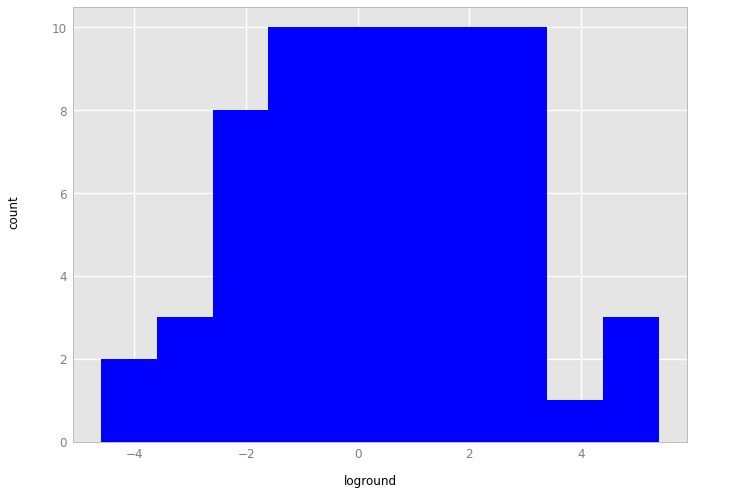

<ggplot: (8759830970089)>


In [49]:
log_ggplot = ggplot(log_df, aes(x='loground', y='count')) + geom_histogram(stat='count',binwidth=1, fill="blue") + theme(title = element_text(size=16),text = element_text(size=14))
print("Log Error Histogram 2016")
print(log_ggplot)

Transaction Month Histogram 2016


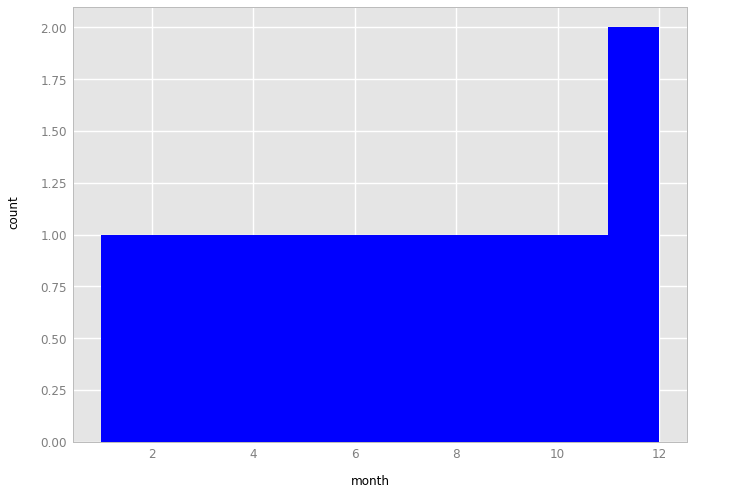

<ggplot: (8759815138685)>


In [50]:
month_ggplot = ggplot(month_df, aes(x='month', y='count')) + geom_histogram(stat='count',binwidth=1, fill="blue") + theme(title = element_text(size=16),text = element_text(size=14))
print("Transaction Month Histogram 2016")
print(month_ggplot)

count    90274.000000
mean         0.011457
std          0.161080
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


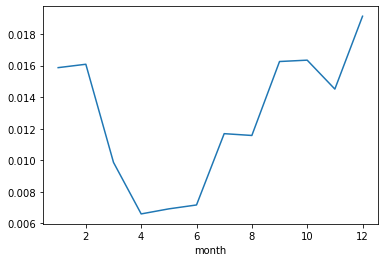

In [51]:
# identity min max log from dataframe
print(train_2016_df['logerror'].describe())

# round log error to nearest 10th
train_2016_df['loground'] = train_2016_df['logerror'].round(1)
month_df = train_2016_df.groupby(['month']).mean()['logerror'].plot()
print(month_df)

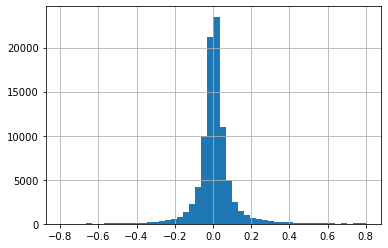

In [52]:
#logerror distribution
train_2016_df.loc[abs(train_2016_df['logerror']) < 0.8, 'logerror'].hist(bins=50)

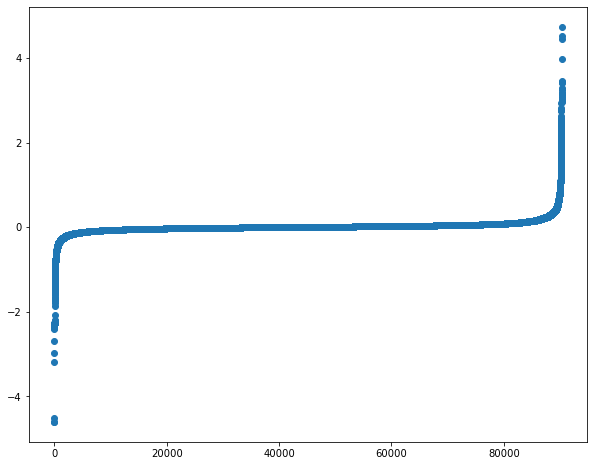

{'whiskers': [<matplotlib.lines.Line2D at 0x7f78db6d8590>,
 'caps': [<matplotlib.lines.Line2D at 0x7f78db6e3050>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f78daf881d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f78db6e3b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f78db6b4090>],
 'means': []}

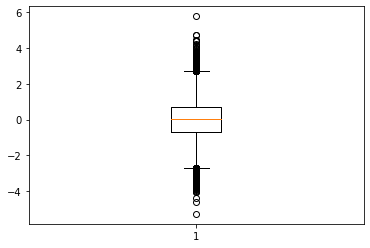

In [53]:
x = range(train_2016_df.shape[0])
y = np.sort(train_2016_df['logerror'])
plt.figure(figsize=(10,8))
plt.scatter(x,y)
plt.show()

plt.boxplot(np.random.normal(train_2016_df['logerror']))

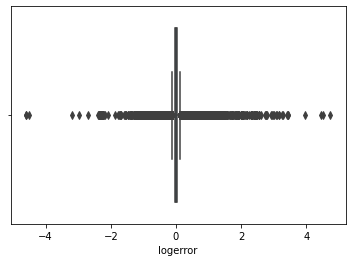

In [54]:
sn.boxplot(x=train_2016_df['logerror'])

Remove the outliers.

In [55]:
limit = 0.6
train_2016_df = train_2016_df[abs(train_2016_df.logerror) <= limit]
print(train_2016_df['logerror'].describe())

count    89323.000000
mean         0.008356
std          0.095041
min         -0.599700
25%         -0.025300
50%          0.005000
75%          0.038300
max          0.599400
Name: logerror, dtype: float64


In [56]:
dt_df = pd.DataFrame(train_2016_df.dtypes.value_counts()).reset_index().rename(columns={"index":"dtype",0:"count"})
dt_df

,dtype,count
0,float64,46
1,int64,13
2,object,3


Questions: What are objects? Arrays?

## **4. Identify Missing Data**
**Summary:** We have identified the data that we are working with and understand the log error distribution, this next part will identify and review data correlation
1. Evaluate which columns are missing data
2. Evaluate column variation
3. Identify data correlation

In [57]:
null_c = train_2016_df.columns[train_2016_df.isnull().any()].tolist()

In [58]:
start_time = time.time()
#process missing column values
null_train_2016_df = train_2016_df[null_c]
print("--- %s seconds to read dataset---" % (time.time() - start_time))

--- 0.0020995140075683594 seconds to read dataset---


In [59]:
null_sum_train_2016 = null_train_2016_df.isnull().sum().sort_values(ascending = False)
null_sum_train_2016

taxdelinquencyyear    13
dtype: int64

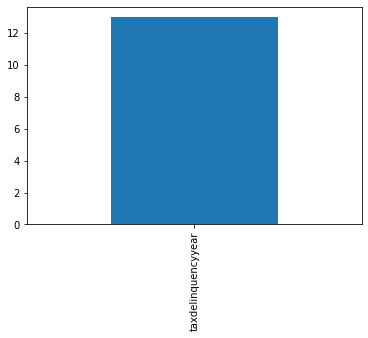

In [60]:
null_sum_train_2016.plot.bar()
plt.show()

In [61]:
print('There are a total of ' + str(len(train_2016_df.columns)) + ' columns in train_2016_df')
print('There are a total of ' + str(len(null_sum_train_2016)) + ' columns that have null data')

There are a total of 62 columns in train_2016_df
There are a total of 1 columns that have null data


Identify outliers of null data, possibly eliminate column with too many null values

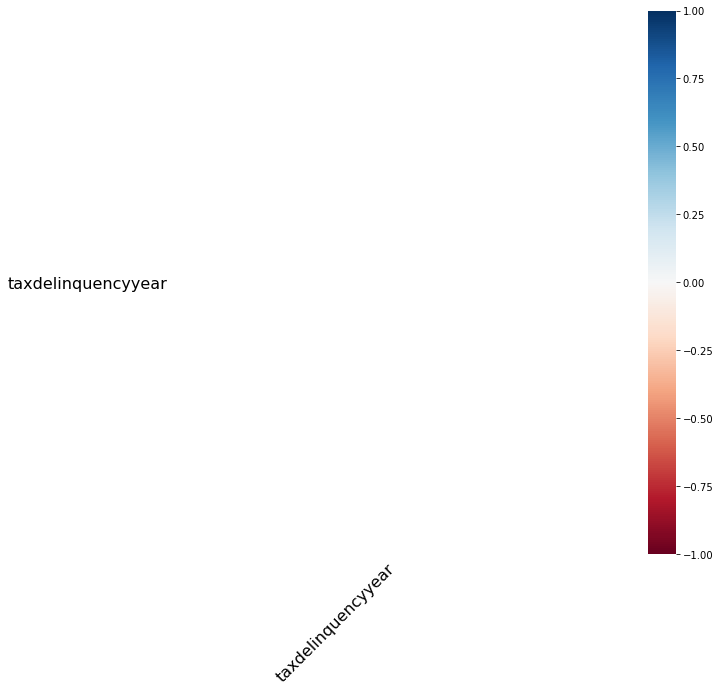

In [62]:
msno.heatmap(train_2016_df[null_c],figsize=(10,10))

In [63]:
all_train_2016_df = train_2016_df.isnull().sum().sort_values(ascending = False)

In [64]:
#percentage of records missing column value
null_percent_train_2016_df = all_train_2016_df/len(train_2016_df)
null_percent_train_2016_df

taxdelinquencyyear              0.000146
loground                        0.000000
finishedsquarefeet12            0.000000
longitude                       0.000000
latitude                        0.000000
heatingorsystemtypeid           0.000000
hashottuborspa                  0.000000
garagetotalsqft                 0.000000
garagecarcnt                    0.000000
fullbathcnt                     0.000000
fireplacecnt                    0.000000
fips                            0.000000
finishedsquarefeet6             0.000000
finishedsquarefeet50            0.000000
finishedsquarefeet15            0.000000
finishedsquarefeet13            0.000000
calculatedfinishedsquarefeet    0.000000
poolcnt                         0.000000
finishedfloor1squarefeet        0.000000
decktypeid                      0.000000
calculatedbathnbr               0.000000
buildingqualitytypeid           0.000000
buildingclasstypeid             0.000000
bedroomcnt                      0.000000
bathroomcnt     

Above - there are a few columns that have almost all values missing, before we drop the columns we will further investigate if there is a strong correlation between the column and the logerror

In [65]:
pearson_corr = train_2016_df.corr(method='pearson')

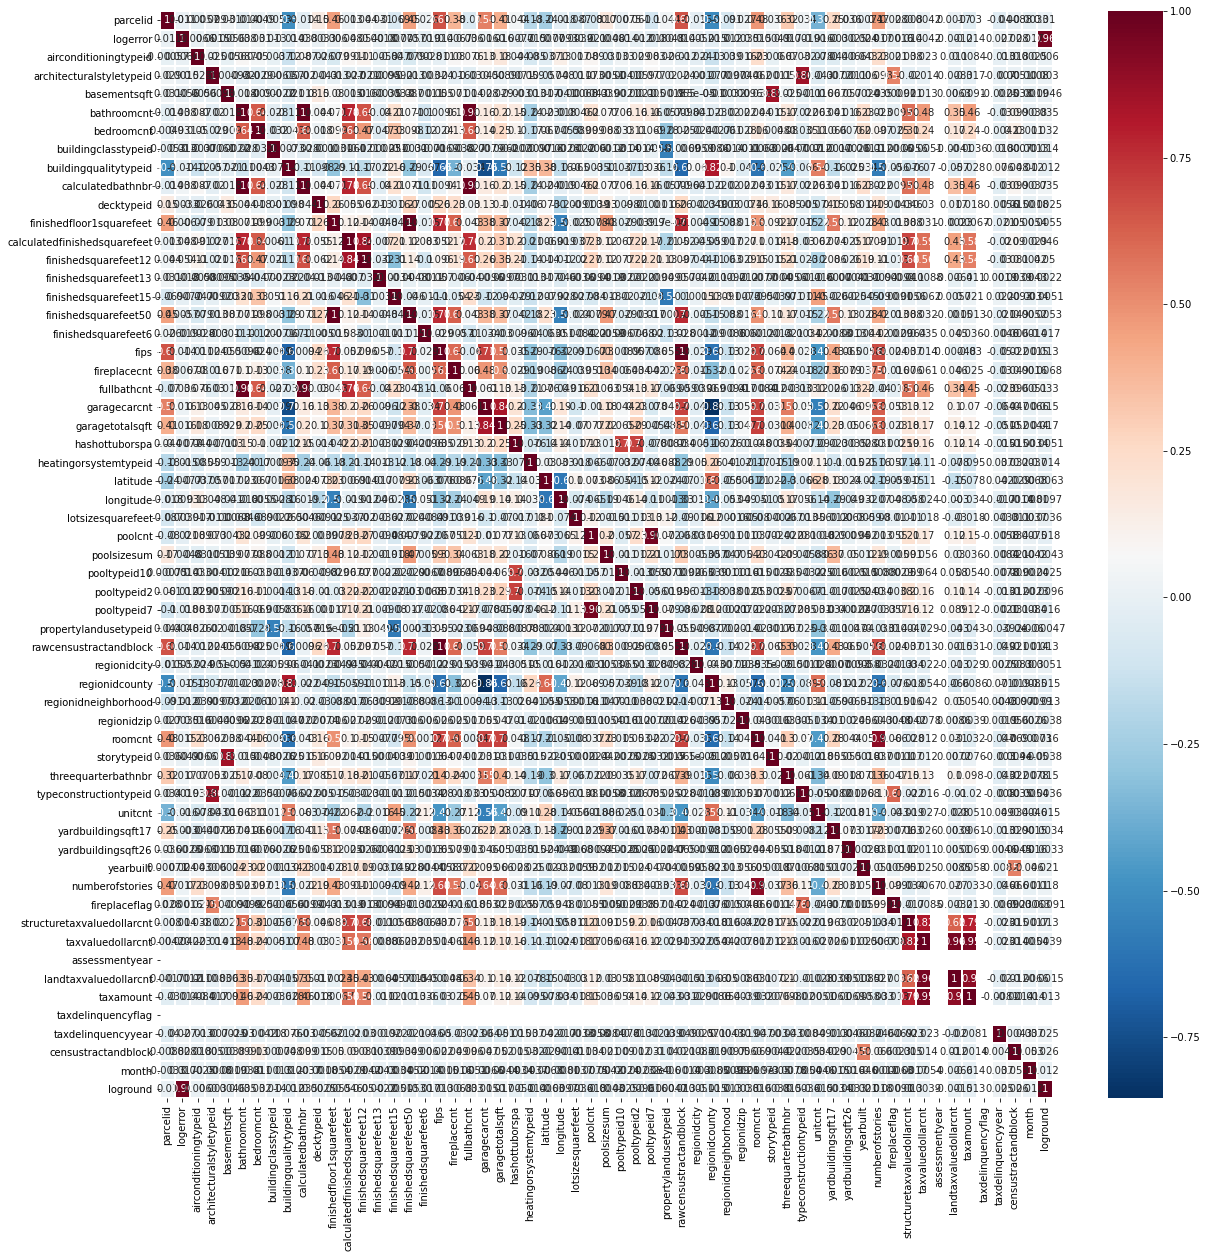

In [66]:
fig, ax = plt.subplots(figsize=(20,20))  

sn.heatmap(pearson_corr, 
            xticklabels=pearson_corr.columns,
            yticklabels=pearson_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=1, ax=ax)

In [67]:
#drop columns with null > .5
null_percent_train_2016_df = null_percent_train_2016_df.where(null_percent_train_2016_df>.5)
null_percent_train_2016_df = null_percent_train_2016_df.notnull()
del_columns = null_percent_train_2016_df[null_percent_train_2016_df]
del_columns = del_columns.index.tolist()

In [68]:
not_null_train_2016_df = train_2016_df.drop(del_columns, axis=1)
#assessmentyear is the same
not_null_train_2016_df = not_null_train_2016_df.drop(['assessmentyear'], axis=1)
not_null_train_2016_df.to_csv('clean_train_2016_df.csv', index=False)

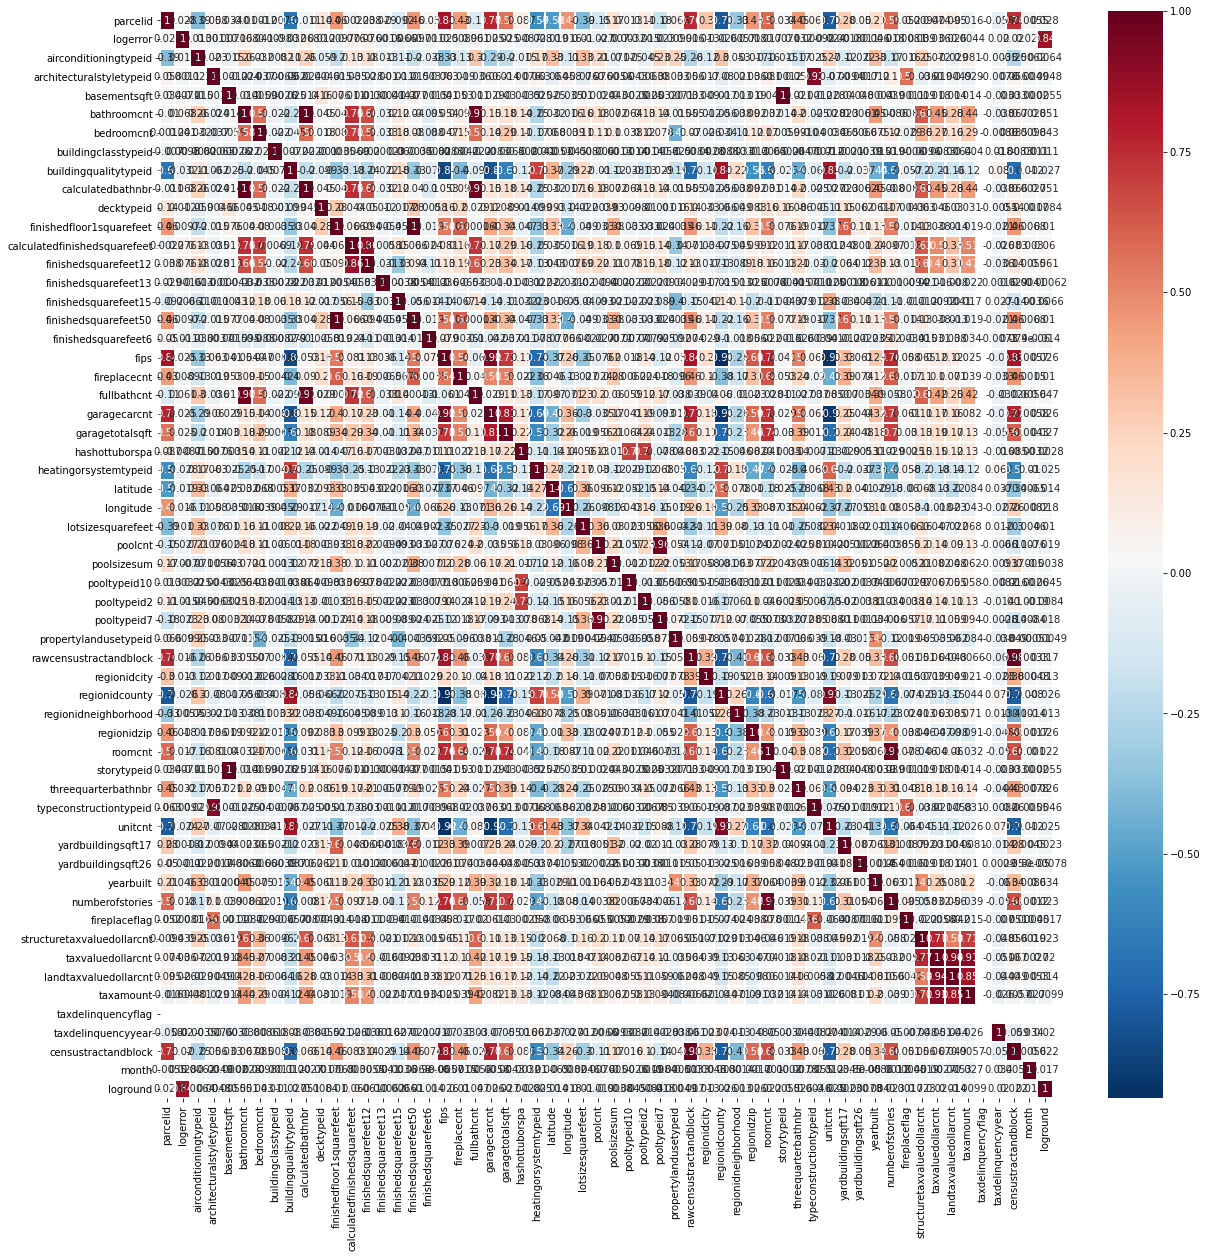

In [69]:
not_null_spearman_corr = not_null_train_2016_df.corr(method='spearman')

fig, ax = plt.subplots(figsize=(20,20))  

sn.heatmap(not_null_spearman_corr, 
            xticklabels=not_null_spearman_corr.columns,
            yticklabels=not_null_spearman_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=1, ax=ax)

In [70]:
not_null_spearman_corr.corr().unstack().sort_values().drop_duplicates()

unitcnt                       garagecarcnt                   -0.989037
fips                          unitcnt                        -0.988729
garagecarcnt                  regionidcounty                 -0.988493
buildingqualitytypeid         garagecarcnt                   -0.983499
regionidcounty                fips                           -0.980192
unitcnt                       rawcensustractandblock         -0.977041
                              censustractandblock            -0.976041
buildingqualitytypeid         fips                           -0.975192
regionidcounty                parcelid                       -0.974838
parcelid                      unitcnt                        -0.974483
regionidcounty                rawcensustractandblock         -0.969392
censustractandblock           regionidcounty                 -0.968606
rawcensustractandblock        buildingqualitytypeid          -0.961994
buildingqualitytypeid         censustractandblock            -0.961603
heatin

ValueError: zero-size array to reduction operation minimum which has no identity

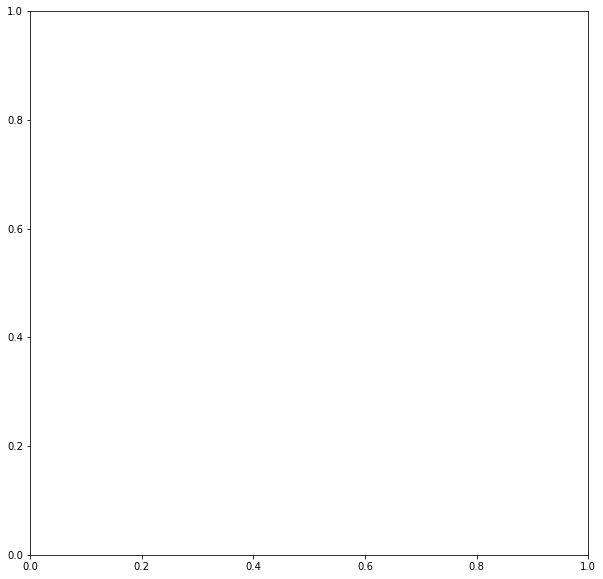

In [71]:
k = 62 
cols = not_null_spearman_corr.nlargest(k, 'logerror')['logerror'].index
cm = np.corrcoef(not_null_spearman_corr[cols].values.T)
f, ax = plt.subplots(figsize=(10, 10))
sn.heatmap(cm, ax=ax, cmap="YlGnBu", linewidths=0.1, yticklabels=cols.values, xticklabels=cols.values)

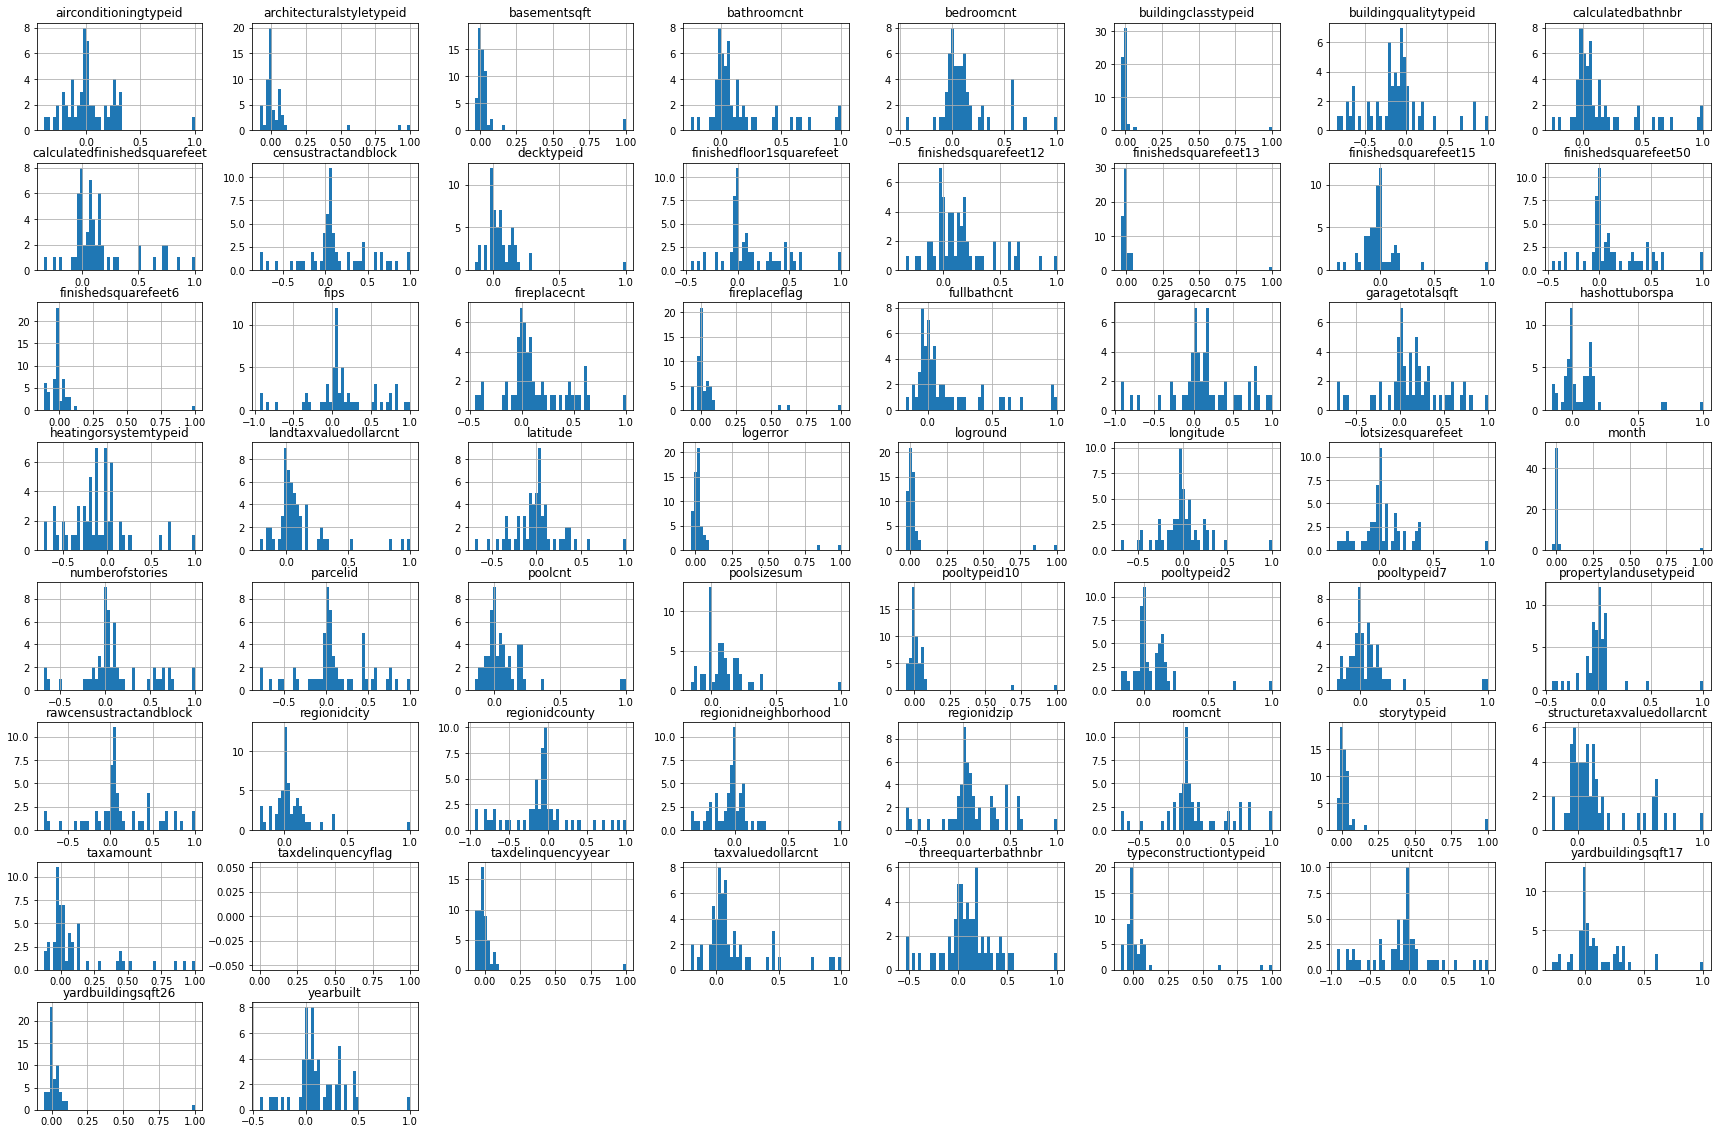

In [72]:
not_null_spearman_corr.hist(bins=50, figsize=(30,20));

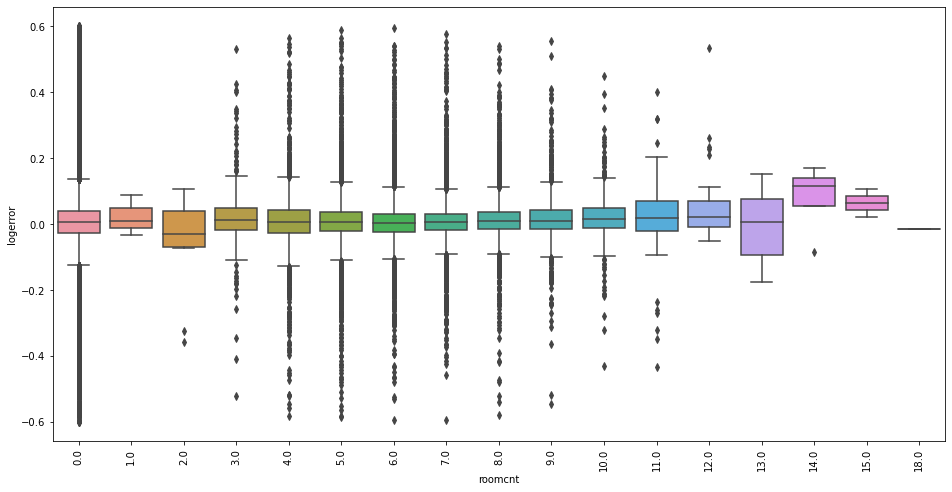

In [73]:
var = 'roomcnt'
data = pd.concat([train_2016_df['logerror'], train_2016_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sn.boxplot(x=var, y="logerror", data=data)
plt.xticks(rotation=90);

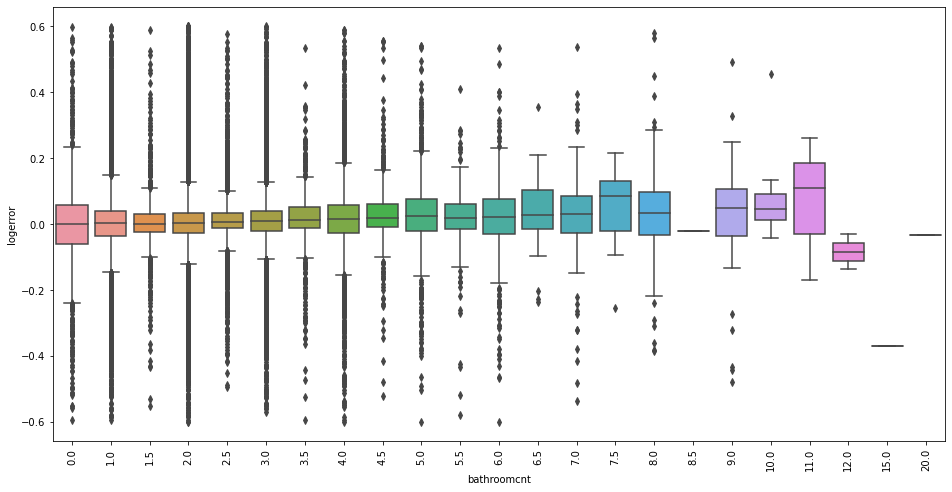

In [74]:
var = 'bathroomcnt'
data = pd.concat([train_2016_df['logerror'], train_2016_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sn.boxplot(x=var, y="logerror", data=data)
plt.xticks(rotation=90);

# **5. Train**
**Summary:** We have cleaned up the null data now we will attempt to train the data set

1. Clean perfectly correlated data - transform
2. Train dataset using GBM

In [75]:
#delete perfectly correlated data to avoid multicollinearity
corr_matrix = not_null_train_2016_df.corr(method="spearman").abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
not_null_train_2016_df.drop(to_drop, axis=1, inplace=True)

In [76]:
print("--- %s seconds to run data manipulation---" % (time.time() - total_time))

--- 374.86306595802307 seconds to run data manipulation---


In [77]:
not_null_train_2016_df.head(10)

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet6,fips,fireplacecnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,month,loground
0,14366692,-0.1684,2016-01-01,0,0,0,3.5,4.0,0,0,0,0.0,2263.0,2263.0,0.0,0.0,0.0,6059,0.0,2.0,468.0,0.0,0.0,33668120,-117677556,3643.0,0.0,0.0,0.0,0.0,1,261.0,unknown,6.059052e+07,32380.0,1286.0,0.0,96962.0,0.0,1.0,0.0,0.0,0.0,0.0,2014.0,0,346458.0,585529.0,239071.0,10153.02,0.0,0.0,1,-0.2
1,12098116,-0.0040,2016-01-01,1,0,0,3.0,2.0,0,4,0,0.0,2217.0,2217.0,0.0,0.0,0.0,6037,0.0,0.0,0.0,0.0,2.0,34136312,-118175032,11423.0,0.0,0.0,0.0,0.0,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.0,96293.0,0.0,0.0,0.0,1.0,0.0,0.0,1940.0,0,61994.0,119906.0,57912.0,11484.48,0.0,0.0,1,-0.0
2,12643413,0.0218,2016-01-02,1,0,0,2.0,2.0,0,4,0,0.0,839.0,839.0,0.0,0.0,0.0,6037,0.0,0.0,0.0,0.0,2.0,33755800,-118309000,70859.0,0.0,0.0,0.0,0.0,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.0,96222.0,0.0,0.0,0.0,1.0,0.0,0.0,1987.0,0,171518.0,244880.0,73362.0,3048.74,0.0,0.0,1,0.0
3,14432541,-0.0050,2016-01-02,0,0,0,2.5,4.0,0,0,0,0.0,2283.0,2283.0,0.0,0.0,0.0,6059,0.0,2.0,598.0,0.0,0.0,33485643,-117700234,6000.0,1.0,0.0,0.0,0.0,122,261.0,unknown,6.059042e+07,17686.0,1286.0,0.0,96961.0,8.0,1.0,0.0,0.0,0.0,0.0,1981.0,0,169574.0,434551.0,264977.0,5488.96,0.0,0.0,1,-0.0
4,11509835,-0.2705,2016-01-02,1,0,0,4.0,4.0,0,1,0,0.0,3067.0,3067.0,0.0,0.0,0.0,6037,0.0,0.0,0.0,0.0,2.0,33870089,-118402768,2708.0,0.0,0.0,0.0,0.0,0100,261.0,HBR3YY,6.037621e+07,29712.0,3101.0,0.0,96109.0,0.0,0.0,0.0,1.0,0.0,0.0,1982.0,0,880650.0,2447951.0,1567301.0,27126.57,0.0,0.0,1,-0.3
5,12286022,0.0440,2016-01-02,0,0,0,1.0,2.0,0,7,0,0.0,1297.0,1297.0,0.0,0.0,0.0,6037,0.0,0.0,0.0,0.0,7.0,33899475,-118212720,6677.0,0.0,0.0,0.0,0.0,0100,261.0,CORH*,6.037542e+07,24174.0,3101.0,0.0,96091.0,0.0,0.0,0.0,1.0,0.0,0.0,1939.0,0,64549.0,111521.0,46972.0,2304.97,0.0,0.0,1,0.0
6,17177301,0.1638,2016-01-02,0,0,0,2.5,3.0,0,0,0,853.0,1763.0,1763.0,0.0,0.0,0.0,6111,1.0,2.0,0.0,0.0,0.0,34207204,-119165589,0.0,0.0,0.0,0.0,0.0,1129,266.0,unknown,6.111003e+07,13150.0,2061.0,0.0,97101.0,6.0,1.0,0.0,0.0,0.0,0.0,1994.0,0,107000.0,306000.0,199000.0,3745.50,0.0,0.0,1,0.2
7,14739064,-0.0030,2016-01-02,0,0,0,1.0,2.0,0,0,0,0.0,796.0,796.0,0.0,0.0,0.0,6059,0.0,1.0,0.0,0.0,0.0,33549600,-117678000,0.0,0.0,0.0,0.0,0.0,34,266.0,unknown,6.059042e+07,25459.0,1286.0,0.0,96987.0,0.0,0.0,0.0,0.0,0.0,0.0,1984.0,0,66834.0,210064.0,143230.0,2172.88,0.0,0.0,1,-0.0
8,14677559,0.0843,2016-01-03,0,0,0,2.0,2.0,0,0,0,0.0,1260.0,1260.0,0.0,0.0,0.0,6059,0.0,1.0,0.0,0.0,0.0,33612700,-117742000,0.0,0.0,0.0,0.0,0.0,34,266.0,unknown,6.059063e+07,46098.0,1286.0,0.0,96963.0,5.0,0.0,0.0,0.0,0.0,0.0,1977.0,0,109977.0,190960.0,80983.0,1940.26,0.0,0.0,1,0.1
9,10854446,0.3825,2016-01-03,0,0,0,2.0,2.0,0,7,0,0.0,1417.0,1417.0,0.0,0.0,0.0,6037,0.0,0.0,0.0,0.0,2.0,34164671,-118477995,8279.0,0.0,0.0,0.0,0.0,0100,261.0,LARE9,6.037141e+07,12447.0,3101.0,51906.0,96426.0,0.0,0.0,0.0,1.0,0.0,0.0,1954.0,0,55396.0,105954.0,50558.0,1443.69,0.0,0.0,1,0.4


In [88]:
# Load data for training set
train =  pd.read_csv('/kaggle/input/zillow-prize-1/train_2016_v2.csv')
prop = pd.read_csv('../input/properties-2016-v2csv/properties_2016_v2.csv')

df_train = train.merge(prop, how='left', on='parcelid')
train_1 = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
train_2 = df_train['logerror'].values
train_columns = train_1.columns

for c in train_1.dtypes[train_1.dtypes == object].index.values:
    train_1[c] = (train_1[c] == True)

split_count = 40000
train_1, train_2, x_valid, y_valid = train_1[:split_count], train_2[:split_count], train_1[split_count:], train_2[split_count:]
train_1 = train_1.values.astype(np.float32, copy=False)
x_valid = x_valid.values.astype(np.float32, copy=False)

train_d1 = lgb.Dataset(train_1, label=train_2)
train_d2 = lgb.Dataset(x_valid, label=y_valid)

params = {}

#best first
params['num_leaves'] = 70
#best accuracy 
params['learning_rate'] = 0.001
#default
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
#mean absolute error - zillow error analysis
params['metric'] = 'mae'

watchlist = [train_d2]
clf = lgb.train(params, train_d1, 500, watchlist)

sample_test = pd.read_csv('/kaggle/input/zillow-prize-1/sample_test_submission.csv')
sample_test['parcelid'] = sample_test['ParcelId']
df_test = sample_test.merge(prop, on='parcelid', how='left')

prop.drop_duplicates(subset=['parcelid'], keep='first', inplace=True)

test_1 = df_test[train_columns]
for c in test_1.dtypes[test_1.dtypes == object].index.values:
    test_1[c] = (test_1[c] == True)
test_1 = test_1.values.astype(np.float32, copy=False)

clf.reset_parameter({"num_threads":1})
test_p = clf.predict(test_1)

sub = pd.read_csv('/kaggle/input/zillow-prize-1/sample_test_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = test_p

[1]	valid_0's l1: 0.0661009
[2]	valid_0's l1: 0.0660998
[3]	valid_0's l1: 0.0660986
[4]	valid_0's l1: 0.0660976
[5]	valid_0's l1: 0.0660964
[6]	valid_0's l1: 0.0660954
[7]	valid_0's l1: 0.0660942
[8]	valid_0's l1: 0.0660932
[9]	valid_0's l1: 0.066092
[10]	valid_0's l1: 0.066091
[11]	valid_0's l1: 0.0660899
[12]	valid_0's l1: 0.0660888
[13]	valid_0's l1: 0.0660878
[14]	valid_0's l1: 0.0660868
[15]	valid_0's l1: 0.0660858
[16]	valid_0's l1: 0.0660848
[17]	valid_0's l1: 0.0660837
[18]	valid_0's l1: 0.0660827
[19]	valid_0's l1: 0.0660817
[20]	valid_0's l1: 0.0660807
[21]	valid_0's l1: 0.0660797
[22]	valid_0's l1: 0.0660787
[23]	valid_0's l1: 0.0660777
[24]	valid_0's l1: 0.0660767
[25]	valid_0's l1: 0.0660757
[26]	valid_0's l1: 0.0660748
[27]	valid_0's l1: 0.066074
[28]	valid_0's l1: 0.0660731
[29]	valid_0's l1: 0.0660722
[30]	valid_0's l1: 0.0660713
[31]	valid_0's l1: 0.0660705
[32]	valid_0's l1: 0.0660697
[33]	valid_0's l1: 0.0660689
[34]	valid_0's l1: 0.0660681
[35]	valid_0's l1: 0.06606

[282]	valid_0's l1: 0.0660006
[283]	valid_0's l1: 0.0660007
[284]	valid_0's l1: 0.0660008
[285]	valid_0's l1: 0.0660009
[286]	valid_0's l1: 0.0660005
[287]	valid_0's l1: 0.066001
[288]	valid_0's l1: 0.0660011
[289]	valid_0's l1: 0.0660014
[290]	valid_0's l1: 0.0660014
[291]	valid_0's l1: 0.0660015
[292]	valid_0's l1: 0.0660017
[293]	valid_0's l1: 0.0660017
[294]	valid_0's l1: 0.066002
[295]	valid_0's l1: 0.066002
[296]	valid_0's l1: 0.0660023
[297]	valid_0's l1: 0.0660023
[298]	valid_0's l1: 0.0660025
[299]	valid_0's l1: 0.0660027
[300]	valid_0's l1: 0.0660026
[301]	valid_0's l1: 0.0660029
[302]	valid_0's l1: 0.0660029
[303]	valid_0's l1: 0.0660028
[304]	valid_0's l1: 0.0660027
[305]	valid_0's l1: 0.0660025
[306]	valid_0's l1: 0.0660023
[307]	valid_0's l1: 0.0660024
[308]	valid_0's l1: 0.0660021
[309]	valid_0's l1: 0.066002
[310]	valid_0's l1: 0.0660018
[311]	valid_0's l1: 0.066002
[312]	valid_0's l1: 0.0660022
[313]	valid_0's l1: 0.066002
[314]	valid_0's l1: 0.0660018
[315]	valid_0's 

FileNotFoundError: [Errno 2] File /kaggle/input/zillow-prize-1/sample_test_submission.csv does not exist: '/kaggle/input/zillow-prize-1/sample_test_submission.csv'

In [85]:
print("--- %s seconds to complete run---" % (time.time() - total_time))

--- 1186.0550796985626 seconds to complete run---


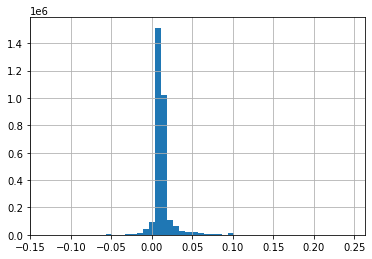

In [86]:
sub['avg'] = sub[['201610', '201611', '201612']].mean(axis=1)
sub.head(10)
#logerror distribution
sub.loc[abs(sub['avg']) < 0.8, 'avg'].hist(bins=50)

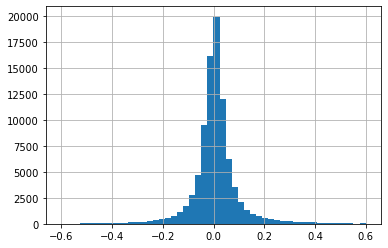

In [87]:
#logerror distribution
train_2016_df.loc[abs(train_2016_df['logerror']) < 0.8, 'logerror'].hist(bins=50)